In [5]:
import geopandas as gpd
import pandas as pd
pd.options.display.max_columns = None
import statsmodels.api as sm
import zipfile

import numpy as np

# read in the shapefile of buncome parcels
parcels = gpd.read_file("./data/Buncombe_County_Parcels/Buncombe_County_Parcels.zip") 
print(parcels.columns)
print(len(parcels))
# read in the CSV file 
zf = zipfile.ZipFile('./data/Appraisal_Tax_History2022/Real_Estate_Appraisal_Tax_History_2022.zip') 
appraisal_tax_history = pd.read_csv(zf.open('Real_Estate_Appraisal_Tax_History_2022.csv'))

# appraisal_tax_history = pd.read_csv("./data/Appraisal_Tax_History2022/Real_Estate_Appraisal_Tax_History_2022.zip",compression='zip') 
print(len(appraisal_tax_history))


Index(['PIN', 'Owner', 'NmpType', 'TaxYear', 'CondoUnit', 'CondoBuild',
       'DeedBook', 'DeedPage', 'PlatBook', 'PlatPage', 'SubName', 'SubLot',
       'SubBlock', 'SubSect', 'UpdateDate', 'HouseNumbe', 'NumberSuff',
       'StreetName', 'StreetType', 'Township', 'Acreage', 'AccountNum',
       'DeedDate', 'Stamps', 'Instrument', 'Reason', 'County', 'City',
       'FireDistri', 'SchoolDist', 'CareOf', 'Address', 'CityName', 'State',
       'Zipcode', 'Class', 'Improved', 'Exempt', 'Priced', 'TotalMarke',
       'AppraisedV', 'TaxValue', 'LandUse', 'Neighborho', 'LandValue',
       'BuildingVa', 'AppraisalA', 'PropCard', 'StreetPref', 'StreetPost',
       'SalePrice', 'objectid', 'ESRI_OID', 'geometry'],
      dtype='object')
131856
2491791


/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_57919/840337364.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  appraisal_tax_history = pd.read_csv(zf.open('Real_Estate_Appraisal_Tax_History_2022.csv'))


In [6]:
# Single family
# 'RES 0-3 ACRES', 'RES >3 ACRES', 'CONDO','TOWNHOME', 'MFG HOME SITE'
parcels =parcels.loc[parcels['Class'].isin(['100','101','120','121','170'])]
print(len(parcels))
parcels_len=len(parcels)

91179


In [7]:
#  For now I'm justing looking a the percent change from 2020 to 2021
appraisal_tax_history = appraisal_tax_history.loc[appraisal_tax_history['TaxYear'] >= 2020]

# Filtering for tax history records that have a PIN in the parcel database
# this might help with computation load for the merge we'll do later
appraisal_tax_history = appraisal_tax_history[appraisal_tax_history['PIN'].isin(parcels['PIN'])] 

# Calculating total valuation from land and bldg valuation. 
appraisal_tax_history['TotalVal'] = appraisal_tax_history['LandVal']+appraisal_tax_history['BldgVal']

#calculate percent change
appraisal_tax_history = appraisal_tax_history.sort_values(by=['PIN','TaxYear'])
appraisal_tax_history['land_value_pct_change'] = appraisal_tax_history.groupby('PIN')['LandVal'].pct_change(periods=1)
appraisal_tax_history['building_value_pct_change'] = appraisal_tax_history.groupby('PIN')['BldgVal'].pct_change(periods=1) 
appraisal_tax_history['total_value_pct_change'] = appraisal_tax_history.groupby('PIN')['TotalVal'].pct_change(periods=1) 


In [8]:
appraisal_tax_history = appraisal_tax_history.loc[appraisal_tax_history['TaxYear'] == 2021.0]
print(len(appraisal_tax_history))

83280


In [9]:

# User inner join here to only anlayse properties that I have a rate change for
# this is to avoid possible parcels that have been recently created, so i don't peg them as having not 
# paid a bill without having been around for the rate increase
merged_data = parcels.merge(appraisal_tax_history, how='inner', left_on='PIN', right_on='PIN')
print(len(merged_data))

merged_data_length_with_percent_change = len(merged_data)
merged_data.head(2)

83280


,PIN,Owner,NmpType,TaxYear_x,CondoUnit,CondoBuild,DeedBook,DeedPage,PlatBook,PlatPage,SubName,SubLot,SubBlock,SubSect,UpdateDate,HouseNumbe,NumberSuff,StreetName,StreetType,Township,Acreage,AccountNum,DeedDate,Stamps,Instrument,Reason,County,City,FireDistri,SchoolDist,CareOf,Address,CityName,State,Zipcode,Class,Improved,Exempt,Priced,TotalMarke,AppraisedV,TaxValue,LandUse,Neighborho,LandValue,BuildingVa,AppraisalA,PropCard,StreetPref,StreetPost,SalePrice,objectid,ESRI_OID,geometry,TaxYear_y,PinOwner,Acres,LandVal,BldgVal,ImprVal,ExemVal,DfrdVal,Exemption,OBJECTID,TotalVal,land_value_pct_change,building_value_pct_change,total_value_pct_change
0,060503100000000,STONE ROBERT K;STONE REBECCA,NaN,24,None,None,1340,0496,0000,0000,None,None,None,None,20230117,23,None,BUTTERROW COVE,RD,20,1.69,69436531;69436532,19710706,1.0,DEE,None,BUN,None,FFA,None,None,23 BUTTERROW COVE RD,FAIRVIEW,NC,28730,100,Y,None,None,296000,296000,296000,None,TSTD,61100,233900,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,1000,121558,74153,"POLYGON ((-82.36073 35.49799, -82.36057 35.497...",2021.0,69436531.0,1.69,61100.0,233900.0,1000.0,0.0,0.0,0,59,295000.0,0.0,0.096064,0.074681
1,060503128800000,MOLLY HAMILTON TRUST,NaN,24,None,None,6282,559,0104,0149,SUGAR HOLLOW ORCHARDS,3,None,None,20230117,5,None,SUGAR HOLLOW ORCHARD,DR,20,1.50,82925343,20221212,0.0,WDT,None,BUN,None,FFA,None,None,5 SUGAR HOLLOW ORCHARD DR,FAIRVIEW,NC,28730,100,Y,None,None,474200,474200,474200,None,SUOA,120000,354200,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,0,76153,74154,"POLYGON ((-82.35906 35.49882, -82.35946 35.498...",2021.0,82248521.0,1.50,120000.0,354200.0,0.0,0.0,0.0,0,75,474200.0,0.0,0.095238,0.069463


In [10]:

unpaid_bills = pd.read_csv("./data/Unpaid_Property_Bills2022/Unpaid_Property_Bills_from_2022.csv")
# This will help identify properties with an unpaid bill, after merging the data.
unpaid_bills['unpaid_bill']=True

print(len(unpaid_bills))
print(len(merged_data))
print(len(parcels))


# Remove leading and trailing white spaces from the "address_line1", "city", "postal_code", "ADDRESS", "CITYNAME", and "ZIPCODE" columns
unpaid_bills['pin'] = unpaid_bills['pin'].str.strip()
merged_data['PIN'] = merged_data['PIN'].str.strip()
parcels['PIN'] = parcels['PIN'].str.strip()

unpaid_bills = unpaid_bills.rename(columns={'pin': 'PIN'})

unpaid_bills['PIN'] = unpaid_bills['PIN'].fillna(value='')
merged_data['PIN'] = merged_data['PIN'].fillna(value='')
parcels['PIN'] = parcels['PIN'].fillna(value='')

unpaid_bills['PIN'] = unpaid_bills['PIN'].astype(str)
merged_data['PIN'] = merged_data['PIN'].astype(str)
parcels['PIN'] = parcels['PIN'].astype(str)

print(len(merged_data))
print('unpaid_bills: ',len(unpaid_bills))

print( unpaid_bills['PIN'].dtype)
print(merged_data['PIN'].dtype)
print( parcels['PIN'].dtype)

# Sort the dataframes on the join column "PIN"
merged_data.sort_values("PIN", inplace=True)
unpaid_bills.sort_values("PIN", inplace=True)
parcels.sort_values("PIN", inplace=True)

#merge left 
merged_data = merged_data.join(unpaid_bills, how='left',
                               lsuffix='', rsuffix='_y', sort=False)
print(len(merged_data))

parcels = parcels.join(unpaid_bills, how='left',
                               lsuffix='', rsuffix='_y', sort=False)
print(len(parcels))

# Originally I had thought to try a secondary merge on address columns,
# because there are many unpaid bills without a 'PIN'
# but a gentelman at the county GIS office told me that unpaid bills with
# a pin would be real-estate related, while thouse without it might be a 
# different type of property. Keeping this here to save the idea.

# unpaid_bills['pin'] = unpaid_bills['pin'].str.replace("-", "")
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].astype(str)
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].astype(object)

# print(merged_data[["Address", "CityName", "Zipcode"]].dtypes)
# print(merged_data['PIN'].dtype)
# print(unpaid_bills['pin'].dtype)
# print(unpaid_bills[["address_line1", "city", "postal_code"]].dtypes)
# unpaid_bills['address_line1']=unpaid_bills['address_line1']+unpaid_bills['address_line2']
# unpaid_bills['address_line1'] = unpaid_bills['address_line1'].str.strip()
# unpaid_bills['city'] = unpaid_bills['city'].str.strip()
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].str.strip()
# merged_data['Address'] = merged_data['Address'].str.strip()
# merged_data['CityName'] = merged_data['CityName'].str.strip()
# merged_data['Zipcode'] = merged_data['Zipcode'].str.strip()

# # Convert the "address_line1", "city", "postal_code", "ADDRESS", "CITYNAME", and "ZIPCODE" columns to lowercase
# unpaid_bills['address_line1'] = unpaid_bills['address_line1'].str.lower()
# unpaid_bills['city'] = unpaid_bills['city'].str.lower()
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].str.lower()
# merged_data['Address'] = merged_data['Address'].str.lower()
# merged_data['CityName'] = merged_data['CityName'].str.lower()
# merged_data['Zipcode'] = merged_data['Zipcode'].str.lower()

#Secondary merge on "Address", "CityName", "Zipcode" and "address_line1", "city", "postal_code"
# merged_data_no_pin = merged_data_no_pin.merge(unpaid_bills, how='left', 
#                                 left_on=['Address', 'CityName'], 
#                                 right_on=['address_line1', 'city'])

# print(len(merged_data_no_pin))
# merged_data = pd.concat([merged_data_no_pin,merged_data]) 
print(len(merged_data))
print(len(parcels))
merged_data['unpaid_bill']=merged_data['unpaid_bill'].fillna(value=False)
parcels['unpaid_bill']=parcels['unpaid_bill'].fillna(value=False)
merged_data.head(2)

21369
83280
91179


/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_57919/949531891.py:1: DtypeWarning: Columns (12,21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  unpaid_bills = pd.read_csv("./data/Unpaid_Property_Bills2022/Unpaid_Property_Bills_from_2022.csv")


83280
unpaid_bills:  21369
object
object
object
83280
91179
83280
91179


,PIN,Owner,NmpType,TaxYear_x,CondoUnit,CondoBuild,DeedBook,DeedPage,PlatBook,PlatPage,SubName,SubLot,SubBlock,SubSect,UpdateDate,HouseNumbe,NumberSuff,StreetName,StreetType,Township,Acreage,AccountNum,DeedDate,Stamps,Instrument,Reason,County,City,FireDistri,SchoolDist,CareOf,Address,CityName,State,Zipcode,Class,Improved,Exempt,Priced,TotalMarke,AppraisedV,TaxValue,LandUse,Neighborho,LandValue,BuildingVa,AppraisalA,PropCard,StreetPref,StreetPost,SalePrice,objectid,ESRI_OID,geometry,TaxYear_y,PinOwner,Acres,LandVal,BldgVal,ImprVal,ExemVal,DfrdVal,Exemption,OBJECTID,TotalVal,land_value_pct_change,building_value_pct_change,total_value_pct_change,acres,active_flag,ad_cost_due,address_line1,address_line2,bill,city,city_code,cost_due,deed_book,deed_date,deed_instrument,deed_page,deferred_value,exempt_value,fees_due,fire_code,house_num,house_suf,interest_due,late_due,levy_due,levy_year,loan_num,mortgage_co,original_bill_amount,owner1_first_name,owner1_last_name,owner1_suffix_name,owner1_third_name,owner2_first_name,owner2_last_name,owner2_suffix_name,owner2_third_name,personal_value,PIN_y,plat_book,plat_page,postal_code,postal_code_ext,real_value,school_code,state,street_direction,street_name,street_type,sub_lot,subdivision,tax_due,total_due,total_value,township,OBJECTID_y,unpaid_bill
0,060503100000000,STONE ROBERT K;STONE REBECCA,NaN,24,None,None,1340,0496,0000,0000,None,None,None,None,20230117,23,None,BUTTERROW COVE,RD,20,1.69,69436531;69436532,19710706,1.0,DEE,None,BUN,None,FFA,None,None,23 BUTTERROW COVE RD,FAIRVIEW,NC,28730,100,Y,None,None,296000,296000,296000,None,TSTD,61100,233900,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,1000,121558,74153,"POLYGON ((-82.36073 35.49799, -82.36057 35.497...",2021.0,69436531.0,1.69,61100.0,233900.0,1000.0,0.0,0.0,0,59,295000.0,0.0,0.096064,0.074681,NaN,NaN,0.0,11 PINE ISLAND DR,NaN,0000762296-2022-2022-0000-00,CANDLER,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,FEC,0.0,0,0.0,26.34,289.74,2022.0,NaN,NaN,289.74,JOSEPH,CHESTER,NaN,NaN,NaN,NaN,NaN,NaN,44419.0,,NaN,NaN,28715.0,8184.0,0.0,NaN,NC,NaN,NaN,NaN,NaN,NaN,263.40,289.74,44419.0,NaN,15036.0,True
1,060503128800000,MOLLY HAMILTON TRUST,NaN,24,None,None,6282,559,0104,0149,SUGAR HOLLOW ORCHARDS,3,None,None,20230117,5,None,SUGAR HOLLOW ORCHARD,DR,20,1.50,82925343,20221212,0.0,WDT,None,BUN,None,FFA,None,None,5 SUGAR HOLLOW ORCHARD DR,FAIRVIEW,NC,28730,100,Y,None,None,474200,474200,474200,None,SUOA,120000,354200,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,0,76153,74154,"POLYGON ((-82.35906 35.49882, -82.35946 35.498...",2021.0,82248521.0,1.50,120000.0,354200.0,0.0,0.0,0.0,0,75,474200.0,0.0,0.095238,0.069463,0.71,1.0,0.0,PO BOX 253,NaN,0000708341-2022-2022-0000-00,RIDGECREST,NaN,0.0,1279,1981/08/26,NON,289,0.0,0.0,0.0,FEB,36.0,NaN,0.0,0.00,429.52,2022.0,NaN,NaN,429.52,DAVID,HALL,NaN,E,THERESA,HALL,NaN,NaN,0.0,0629-48-5739-00000,32,47,28770.0,253.0,72200.0,NaN,NC,NaN,LOCUST,ST,255,RIDGECREST,429.52,429.52,72200.0,NaN,18068.0,True


In [11]:
# Get vars from census for logistic regression

import cenpy

vars_to_download = {
    "B25077_001E": "median_house_value",  # Median house value
    "B02001_002E": "total_pop_white",     # Total white population
    "B01003_001E": "total_pop",           # Total population
    "B25003_003E": "total_rented",        # Total rented occupied
    "B25001_001E": "total_housing_units", # Total housing units
    "B09019_006E": "hh_female",           # Female households
    "B09019_001E": "hh_total",            # Total households
    "B15003_002E": "total_bachelor",      # Total w/ Bachelor degree
    "B25018_001E": "median_no_rooms",     # Median number of rooms
    "B19083_001E": "income_gini",         # Gini index of income inequality
    "B01002_001E": "median_age",          # Median age
    "B08303_001E": "tt_work",              # Aggregate travel time to work
    "B19013_001E": "median_hh_income"     # Median household income
}
vars_to_download_l = list(vars_to_download.keys())

acs = cenpy.products.ACS()
tracts = acs.from_county('Buncombe, NC',level='tract',variables=vars_to_download)
tracts = tracts.rename(columns=vars_to_download)

tracts["pct_rented"] = tracts["total_rented"] / \
                  (tracts["total_housing_units"] + \
                   (tracts["total_housing_units"]==0) * 1
                  )
tracts["pct_hh_female"] = tracts["hh_female"] / \
                  (tracts["hh_total"] + \
                   (tracts["hh_total"]==0) * 1
                  )
tracts["pct_bachelor"] = tracts["total_bachelor"] / \
                  (tracts["total_pop"] + \
                   (tracts["total_pop"]==0) * 1
                  )

tracts["pct_white"] = tracts["total_pop_white"] / \
                  (tracts["total_pop"] + \
                   (tracts["total_pop"]==0) * 1
                  )

tracts

,GEOID,geometry,median_age,total_pop,total_pop_white,tt_work,hh_total,hh_female,total_bachelor,median_hh_income,income_gini,total_housing_units,total_rented,median_no_rooms,median_house_value,NAME,state,county,tract,pct_rented,pct_hh_female,pct_bachelor,pct_white
0,37021000300,"POLYGON ((-9192794.270 4246732.450, -9192786.5...",30.5,2396.0,1789.0,1215.0,2396.0,278.0,9.0,44551.0,0.5234,1091.0,547.0,5.5,400600.0,"Census Tract 3, Buncombe County, North Carolina",37,021,000300,0.501375,0.116027,0.003756,0.746661
1,37021001600,"POLYGON ((-9193389.940 4255045.010, -9193388.5...",48.7,6514.0,6211.0,2037.0,6514.0,1109.0,31.0,70125.0,0.4549,3345.0,1087.0,6.4,474300.0,"Census Tract 16, Buncombe County, North Carolina",37,021,001600,0.324963,0.170249,0.004759,0.953485
2,37021000800,"POLYGON ((-9189569.680 4242651.490, -9189560.6...",44.0,3454.0,2844.0,1902.0,3454.0,424.0,18.0,58594.0,0.4048,1746.0,776.0,5.6,358200.0,"Census Tract 8, Buncombe County, North Carolina",37,021,000800,0.444444,0.122756,0.005211,0.823393
3,37021002000,"POLYGON ((-9188930.820 4241348.570, -9188923.0...",39.4,6446.0,4612.0,2848.0,6446.0,753.0,46.0,41574.0,0.3984,3249.0,1412.0,4.9,174300.0,"Census Tract 20, Buncombe County, North Carolina",37,021,002000,0.434595,0.116817,0.007136,0.715482
4,37021002203,"POLYGON ((-9190515.450 4225046.190, -9190498.5...",41.4,4429.0,3521.0,2222.0,4429.0,550.0,16.0,41392.0,0.4826,2554.0,1288.0,5.0,162400.0,"Census Tract 22.03, Buncombe County, North Car...",37,021,002203,0.504307,0.124182,0.003613,0.794988
5,37021003001,"POLYGON ((-9183487.190 4250193.650, -9183478.8...",45.1,9026.0,8052.0,3893.0,9026.0,1144.0,119.0,57607.0,0.4443,3937.0,626.0,6.0,252100.0,"Census Tract 30.01, Buncombe County, North Car...",37,021,003001,0.159004,0.126745,0.013184,0.892090
6,37021003103,"POLYGON ((-9169834.410 4242163.290, -9169833.4...",53.2,1888.0,1782.0,924.0,1888.0,263.0,0.0,52500.0,0.3952,1141.0,201.0,6.1,214600.0,"Census Tract 31.03, Buncombe County, North Car...",37,021,003103,0.176161,0.139301,0.000000,0.943856
7,37021001200,"POLYGON ((-9198979.410 4240106.020, -9198960.0...",37.8,4903.0,4691.0,2312.0,4903.0,889.0,22.0,54811.0,0.4055,2398.0,997.0,5.0,280000.0,"Census Tract 12, Buncombe County, North Carolina",37,021,001200,0.415763,0.181318,0.004487,0.956761
8,37021001100,"POLYGON ((-9196016.860 4240940.350, -9196014.6...",36.7,5573.0,4626.0,3054.0,5573.0,627.0,16.0,62851.0,0.3973,2490.0,970.0,5.7,272500.0,"Census Tract 11, Buncombe County, North Carolina",37,021,001100,0.389558,0.112507,0.002871,0.830074
9,37021001000,"POLYGON ((-9193560.710 4241161.500, -9193531.5...",32.9,4811.0,4019.0,2537.0,4811.0,745.0,9.0,56298.0,0.4612,2157.0,850.0,5.3,279100.0,"Census Tract 10, Buncombe County, North Carolina",37,021,001000,0.394066,0.154853,0.001871,0.835377


In [28]:
type(tracts)

geopandas.geodataframe.GeoDataFrame

In [12]:
merged_data["total_due"].value_counts(dropna=False)

NaN       61911
32.99        32
23.07        31
21.96        29
30.00        21
          ...  
558.95        1
975.20        1
277.52        1
83.23         1
56.91         1
Name: total_due, Length: 17712, dtype: int64

In [13]:
merged_data["Class"].value_counts(dropna=False)

100    62298
170     8336
101     4897
120     4409
121     3340
Name: Class, dtype: int64

In [14]:
merged_data['unpaid_bill'].value_counts(dropna=False)
# Lingering question: If your taxeble value changes in 2021 
# when is the first time you'd pay taxes on the new amount? 
# I'm using billing data from 2022 beacuse, to be on the safer side.

False    61911
True     21369
Name: unpaid_bill, dtype: int64

In [15]:
# Check how many preperties don't have a percent change
print(len(merged_data))
print(merged_data_length_with_percent_change)
merged_data["total_value_pct_change"].value_counts(dropna=False)

83280
83280


NaN         1394
0.000000     428
0.371257      64
0.319672      62
0.250000      57
            ... 
0.200411       1
0.221501       1
0.229254       1
0.217112       1
0.344164       1
Name: total_value_pct_change, Length: 72754, dtype: int64

In [16]:
# only want to look at houses for which I hav a percent incerase
merged_data = merged_data[~merged_data["total_value_pct_change"].isnull()]
merged_data["total_value_pct_change"].value_counts(dropna=False)

0.000000    428
0.371257     64
0.319672     62
0.250000     57
0.621475     56
           ... 
0.200411      1
0.221501      1
0.229254      1
0.217112      1
0.344164      1
Name: total_value_pct_change, Length: 72753, dtype: int64

In [17]:
import statsmodels.api as sm

print(merged_data[['total_value_pct_change','unpaid_bill']].isna().sum())
# Prepare the data

# quick check for inf values
df = merged_data[['total_value_pct_change','unpaid_bill']]
number_inf = df[df == np.inf].count()
print(number_inf)

# prepare data from regression
merged_data['total_value_pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.dropna(subset=["total_value_pct_change"], how="all", inplace=True)

# Multiply to make coef easier to interpret. 
merged_data['total_value_pct_change'] = merged_data['total_value_pct_change']*100


X = merged_data['total_value_pct_change']
print(len(X))
y = merged_data['unpaid_bill']
print(len(y))
# Fit the logistic regression model
logit = sm.Logit(y, X)
result = logit.fit()
print(result.summary())

# I still need to check for linearity


total_value_pct_change    0
unpaid_bill               0
dtype: int64
total_value_pct_change    1
unpaid_bill               0
dtype: int64
81885
81885
Optimization terminated successfully.
         Current function value: 0.649529
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            unpaid_bill   No. Observations:                81885
Model:                          Logit   Df Residuals:                    81884
Method:                           MLE   Df Model:                            0
Date:                Sun, 29 Jan 2023   Pseudo R-squ.:                 -0.1420
Time:                        23:33:10   Log-Likelihood:                -53187.
converged:                       True   LL-Null:                       -46574.
Covariance Type:            nonrobust   LLR p-value:                       nan
                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

<AxesSubplot: xlabel='total_value_pct_change', ylabel='unpaid_bill'>

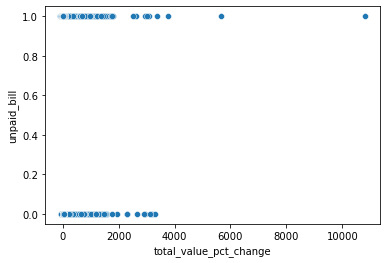

In [18]:
import seaborn as sns
sns.scatterplot(x='total_value_pct_change', y='unpaid_bill', data=merged_data)

In [19]:
# top_10_highest_values = merged_data.nlargest(5, 'TotalVal')
# top_10_highest_values

In [22]:
quintiles = merged_data['TotalVal'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
array_q = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
merged_data['TotalVal_quintile'] = pd.cut(merged_data['TotalVal'], quintiles, labels=array_q)

# Loop through quintiles and run a logistic regression
for quintile in array_q:
    merged_data_quintile = merged_data[merged_data['TotalVal_quintile'] == quintile]
    Xx = merged_data_quintile['total_value_pct_change']
    Yy = merged_data_quintile['unpaid_bill']
    print(f'Coefficients for quintile {quintile}')
    logit = sm.Logit(Yy, Xx)
    result = logit.fit()
    print(result.summary())
    

Coefficients for quintile Q1
Optimization terminated successfully.
         Current function value: 0.674910
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            unpaid_bill   No. Observations:                16387
Model:                          Logit   Df Residuals:                    16386
Method:                           MLE   Df Model:                            0
Date:                Sun, 29 Jan 2023   Pseudo R-squ.:                -0.01942
Time:                        23:35:24   Log-Likelihood:                -11060.
converged:                       True   LL-Null:                       -10849.
Covariance Type:            nonrobust   LLR p-value:                       nan
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
total_value_pct_change    -0.0110      0.000    -22.221

In [23]:
#  total unpaid bill rate
parcels['unpaid_bill'].mean()

0.14158962041698198

91179

 --------
Raw totals quintiles:
TaxVal_quintile
(0.0, 164400.0]          3636
(164400.0, 237900.0]     2779
(237900.0, 304200.0]     2333
(304200.0, 420100.0]     2305
(420100.0, 8505800.0]    1666
Name: unpaid_bill, dtype: int64

 --------
Total_counts quintiles:
TaxVal_quintile
(0.0, 164400.0]          17072
(164400.0, 237900.0]     18273
(237900.0, 304200.0]     18203
(304200.0, 420100.0]     18236
(420100.0, 8505800.0]    18230
Name: TaxValue, dtype: int64

 --------
rate raw_counts / total_counts by quintile:
TaxVal_quintile
(0.0, 164400.0]          0.212980
(164400.0, 237900.0]     0.152082
(237900.0, 304200.0]     0.128166
(304200.0, 420100.0]     0.126398
(420100.0, 8505800.0]    0.091388
dtype: float64
TaxVal_quintile        unpaid_bill
(0.0, 164400.0]        False          13436
                       True            3636
(164400.0, 237900.0]   False          15494
                       True            2779
(237900.0, 304200.0]   False          15870
                 

/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_57919/3226777851.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


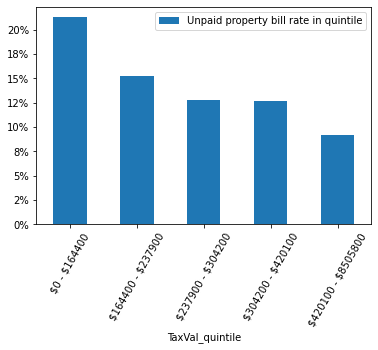

In [44]:
# Here I'm checking to see which quintiles have more unpaid bills.
#switching back to using all parcels to include those I filtered out
#when cleaning for the previous section, but an argument could probably be made to use either.
import matplotlib.pyplot as plt
print(len(parcels))
quintiles = parcels['TaxValue'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
array_q = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
parcels['TaxVal_quintile'] = pd.cut(parcels['TaxValue'], quintiles)


grouped_quintiles = parcels.groupby('TaxVal_quintile')

# Get the raw number of true 'unpaid_bill' variables in each quintile
raw_counts_quintiles = grouped_quintiles['unpaid_bill'].sum()

# Get the total number of records in each quintile
total_counts_quintiles = grouped_quintiles['TaxValue'].count()

# Get the ratio of true 'unpaid_bill' variables in each quintile
ratio_quintiles = raw_counts_quintiles / total_counts_quintiles
print('\n --------')
print('Raw totals quintiles:')
print(raw_counts_quintiles)
print('\n --------')
print('Total_counts quintiles:')
print(total_counts_quintiles)
print('\n --------')
print('rate raw_counts / total_counts by quintile:')
print(ratio_quintiles)

print(parcels.groupby('TaxVal_quintile')['unpaid_bill'].value_counts(dropna=False))
quintiles_rates =parcels.groupby('TaxVal_quintile')['unpaid_bill'].agg(['count', 'sum', 'mean']).reset_index()
fig, ax = plt.subplots()
quintiles_rates.plot.bar(x='TaxVal_quintile', y='mean', rot=0,ax=ax)

x_labels = [f"\${int(i.left)} - \${int(i.right)}" for i in parcels['TaxVal_quintile'].cat.categories]
print(x_labels)
ax.set_xticklabels(x_labels,rotation=60)

ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

ax.legend(["Unpaid property bill rate in quintile"]);
plt.savefig('images/unpaid_property_bill_quintile_rates.png', dpi=300)

Deciles
 --------
Raw totals:
TaxVal_deciles
(0.0, 105300.0]          1829
(105300.0, 164400.0]     1807
(164400.0, 205200.0]     1465
(205200.0, 237900.0]     1314
(237900.0, 269300.0]     1198
(269300.0, 304200.0]     1135
(304200.0, 350200.0]     1208
(350200.0, 420100.0]     1097
(420100.0, 561100.0]     1004
(561100.0, 8505800.0]     662
Name: unpaid_bill, dtype: int64

 --------
Total_counts:
TaxVal_deciles
(0.0, 105300.0]          7958
(105300.0, 164400.0]     9114
(164400.0, 205200.0]     9124
(205200.0, 237900.0]     9149
(237900.0, 269300.0]     9102
(269300.0, 304200.0]     9101
(304200.0, 350200.0]     9132
(350200.0, 420100.0]     9104
(420100.0, 561100.0]     9113
(561100.0, 8505800.0]    9117
Name: TaxValue, dtype: int64

 --------
rate raw_counts / total_counts:
TaxVal_deciles
(0.0, 105300.0]          0.229832
(105300.0, 164400.0]     0.198266
(164400.0, 205200.0]     0.160566
(205200.0, 237900.0]     0.143622
(237900.0, 269300.0]     0.131619
(269300.0, 304200.0]     0

/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_57919/2726491790.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


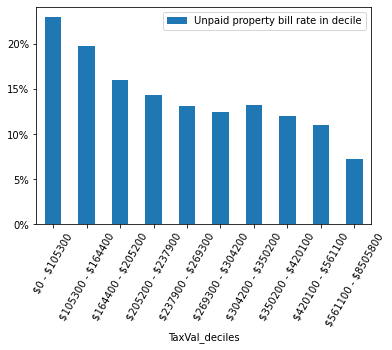

In [43]:
# Doing the same thing here for all deciles
deciles = parcels['TaxValue'].quantile([0,0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1])
parcels['TaxVal_deciles'] = pd.cut(parcels['TaxValue'], deciles)


grouped_deciles = parcels.groupby('TaxVal_deciles')

# Get the raw number of true 'unpaid_bill' variables in each decile
raw_counts_deciles = grouped_deciles['unpaid_bill'].sum()

# Get the total number of records in each decile
total_counts_deciles = grouped_deciles['TaxValue'].count()

# Get the ratio of true 'unpaid_bill' variables in each decile
ratio_deciles = raw_counts_deciles / total_counts_deciles
print('Deciles\n --------')
print('Raw totals:')
print(raw_counts_deciles)
print('\n --------')
print('Total_counts:')
print(total_counts_deciles)
print('\n --------')
print('rate raw_counts / total_counts:')
print(ratio_deciles)

print(parcels.groupby('TaxVal_deciles')['unpaid_bill'].value_counts(dropna=False))
decile_rates=parcels.groupby('TaxVal_deciles')['unpaid_bill'].agg(['count', 'sum', 'mean']).reset_index()


# Modify the x-axis labels


fig, ax = plt.subplots()
decile_rates.plot.bar(x='TaxVal_deciles', y='mean', rot=0,ax=ax)
x_labels = [f"\${int(i.left)} - \${int(i.right)}" for i in parcels['TaxVal_deciles'].cat.categories]
print(x_labels)
ax.set_xticklabels(x_labels,rotation=60)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

ax.legend(["Unpaid property bill rate in decile"]);
plt.savefig('images/unpaid_property_bill_decile_rates.png', dpi=300)

In [ ]:
import pydeck

DATA_URL = "https://raw.githubusercontent.com/visgl/deck.gl-data/master/examples/geojson/vancouver-blocks.json"
LAND_COVER = [[[-123.0, 49.196], [-123.0, 49.324], [-123.306, 49.324], [-123.306, 49.196]]]

INITIAL_VIEW_STATE = pydeck.ViewState(
  latitude=49.254,
  longitude=-123.13,
  zoom=11,
  max_zoom=16,
  pitch=45,
  bearing=0
)

polygon = pydeck.Layer(
    'PolygonLayer',
    LAND_COVER,
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon='-',
    get_fill_color=[0, 0, 0, 20]
)

geojson = pydeck.Layer(
    'GeoJsonLayer',
    DATA_URL,
    opacity=0.8,
    stroked=False,
    filled=True,
    extruded=True,
    wireframe=True,
    get_elevation='properties.valuePerSqm / 20',
    get_fill_color='[255, 255, properties.growth * 255]',
    get_line_color=[255, 255, 255],
    pickable=True
)

r = pydeck.Deck(
    layers=[polygon, geojson],
    initial_view_state=INITIAL_VIEW_STATE)

r.to_html()